# Frequency modulated continuous wave (FMCW) radar

# 1. Introduction
- Should be putting together all the concepts we've learned

# 2. Range estimation

# 3. Velocity Estimation

# 4. Range-Doppler map
- blocking N chirps to estimate velocity over

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light
BW = 150e6  # bandwidth
fc = 77e9  # carrier frequency
n_adc = 256  # number of adc samples
n_chirp = 512 # Number of chirps per "image"
T = 10e-6  # PRI 
PRF = 1/T
f_s = n_adc/T  # sampling frequency
dt = 1/f_s  # sampling interval
chirp_rate = BW/T
wavelen = speed_of_light/fc
fast_time = dt * np.arange(0, n_adc)
slow_time = T * np.arange(n_chirp)
n_transmitters = 1
n_receivers = 512
max_velocity = wavelen/(T*4)  # Max unambiguous velocity m/s
range_resolution = speed_of_light/(2*BW)
max_range = f_s*speed_of_light/(2*chirp_rate) 
d_rx = wavelen/2  # distance between receivers
d_tx = 4*d_rx  # distance between transmitters

# Range, velocity, and angle axes
R = range_resolution * np.arange(fast_time.size)
# R = np.arange(0, max_range, range_resolution)  # range axis
V = np.linspace(-max_velocity, max_velocity, n_chirp)  # Velocity axis
ang_ax = np.arange(-90, 90, 1)  # angle axis
print(R)



[  0.           0.99930819   1.99861639   2.99792458   3.99723277
   4.99654097   5.99584916   6.99515735   7.99446555   8.99377374
   9.99308193  10.99239013  11.99169832  12.99100651  13.99031471
  14.9896229   15.98893109  16.98823929  17.98754748  18.98685567
  19.98616387  20.98547206  21.98478025  22.98408845  23.98339664
  24.98270483  25.98201303  26.98132122  27.98062941  28.97993761
  29.9792458   30.97855399  31.97786219  32.97717038  33.97647857
  34.97578677  35.97509496  36.97440315  37.97371135  38.97301954
  39.97232773  40.97163593  41.97094412  42.97025231  43.96956051
  44.9688687   45.96817689  46.96748509  47.96679328  48.96610147
  49.96540967  50.96471786  51.96402605  52.96333425  53.96264244
  54.96195063  55.96125883  56.96056702  57.95987521  58.95918341
  59.9584916   60.95779979  61.95710799  62.95641618  63.95572437
  64.95503257  65.95434076  66.95364895  67.95295715  68.95226534
  69.95157353  70.95088173  71.95018992  72.94949811  73.94880631
  74.94811

In [137]:
print(fast_time[-1] - fast_time[0])
print(slow_time[1])


9.9609375e-06
1e-05


<Figure size 640x480 with 0 Axes>

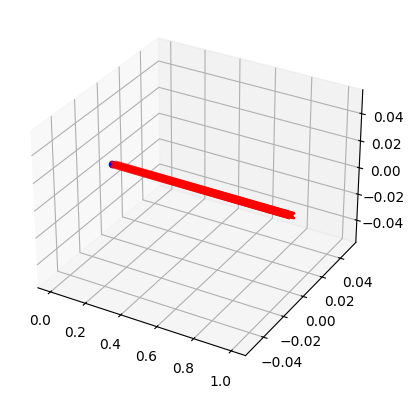

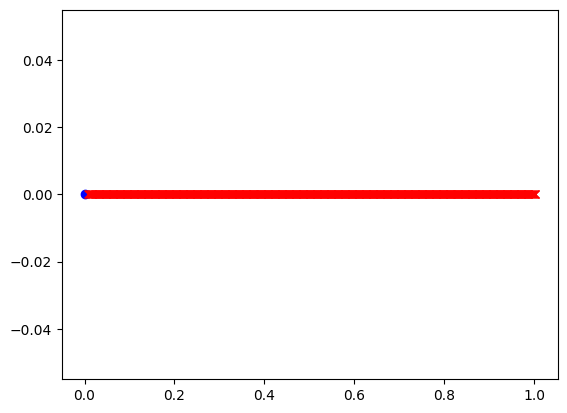

In [147]:
# Setup the antennas
tx_loc = np.zeros((n_transmitters, 3))
tx_loc[:, 0] = d_tx * np.arange(n_transmitters)

rx_loc = np.zeros((n_receivers, 3))
rx_loc[:, 0] = tx_loc[-1][0] + d_tx + d_rx * np.arange(n_receivers)

fig = plt.figure()
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.scatter(tx_loc[:, 0], tx_loc[:, 1], tx_loc[:, 2], color='b', marker='o')
ax.scatter(rx_loc[:, 0], rx_loc[:, 1], rx_loc[:, 2], color='r', marker='x')
plt.figure()
plt.plot(tx_loc[:, 0], tx_loc[:, 1], 'bo')
plt.plot(rx_loc[:, 0], rx_loc[:, 1], 'rx')



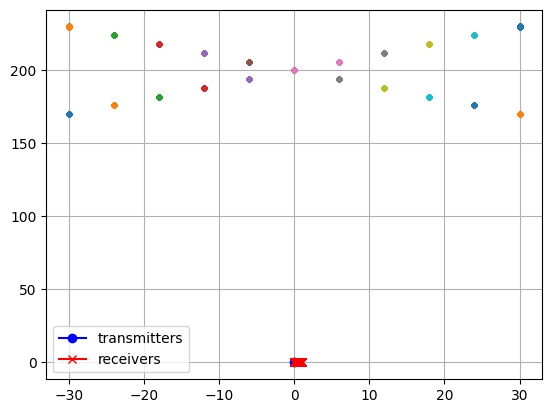

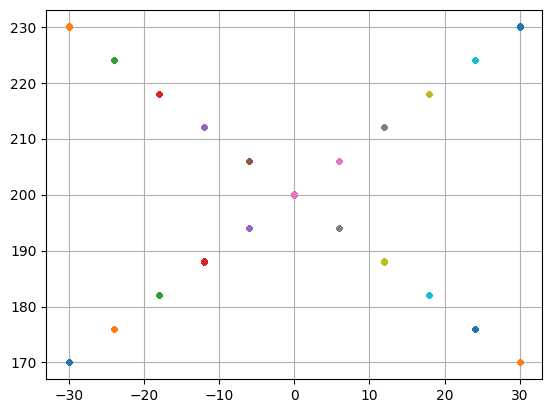

In [160]:
# set up targets
def create_target(pos, vel):
    _pos = np.zeros(3)
    _vel = np.zeros(3)
    _pos[0] = pos[0]
    _pos[1] = pos[1]

    _vel[0] = vel[0]
    _vel[1] = vel[1]
    return _pos + _vel[None, :] * slow_time[:, None]

targets = [
    create_target(
        pos=(pos, 200 + pos),
        # vel=(5, pos)
        vel=(0, 10)
    )
    for pos in np.linspace(-30, 30, 11)
    
] + [
    create_target(
        pos=(pos, 200 - pos),
        # vel=(5, pos)
        vel=(0, 10)
    )
    for pos in np.linspace(-30, 30, 11)
]

# t2_pos = np.array([70, 0, 0])
# t2_vel = np.array([-20, 0, 0])

# t2_loc = t2_pos + t2_vel[None, :] * slow_time[:, None]

# t3_pos = np.array([70, 30, 0])
# t3_vel = np.array([0, 0, 0])
# t3_loc = t3_pos + t3_vel[None, :] * slow_time[:, None]

plt.figure()
plt.plot(tx_loc[:, 0], tx_loc[:, 1], color='b', marker='o', label='transmitters')
plt.plot(rx_loc[:, 0], rx_loc[:, 1], color='r', marker='x', label='receivers')
for tgt in targets:
    plt.plot(tgt[:, 0], tgt[:, 1], '.')
plt.legend()
plt.grid()

plt.figure()
for tgt in targets:
    plt.plot(tgt[:, 0], tgt[:, 1], '.')
plt.grid()

In [161]:
# compute delays to targets
delays = np.zeros((n_transmitters, n_receivers, len(targets), slow_time.size))
distances = np.zeros((n_transmitters, n_receivers, len(targets), slow_time.size))
for i, tx_pos in enumerate(tx_loc):
    for j, rx_pos in enumerate(rx_loc):
        for k, tgt in enumerate(targets):
            tx_to_target = np.linalg.norm(tgt - tx_pos, axis=-1)
            rx_to_target = np.linalg.norm(tgt - rx_pos, axis=-1)
            distances[i, j, k, :] = (tx_to_target + rx_to_target)  # just for debugging 
            delays[i, j, k, :] = distances[i, j, k, :] / (speed_of_light)
delays.shape


(1, 512, 22, 512)

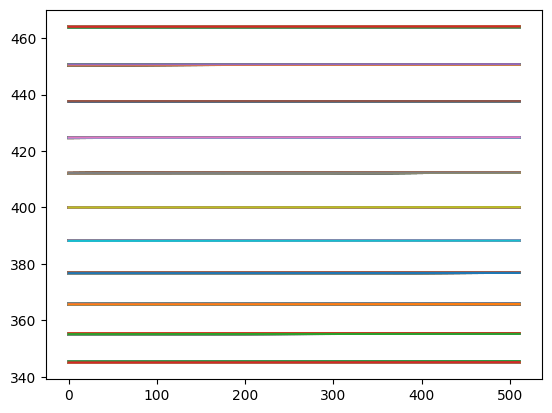

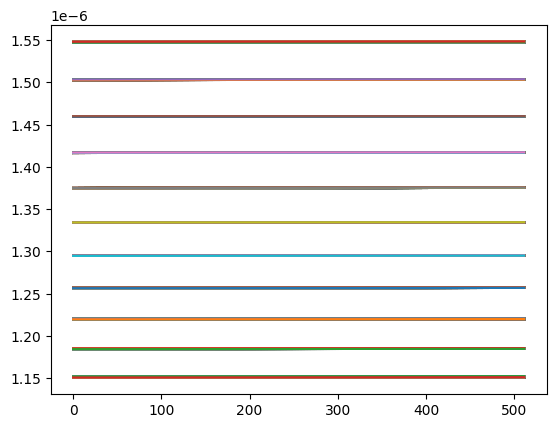

In [162]:
# plt.figure()
# plt.plot(delays[0, 0, :], '.')
# plt.grid()
# print(delays[0, 0, :].min())
# print(delays[0, 0, :].max())

plt.figure()
for i in range(n_receivers):
    for k in range(len(targets)):
        plt.plot(distances[0, i, k, :])
plt.figure()
for i in range(n_receivers):
    for k in range(len(targets)):
        plt.plot(delays[0, i, k, :])
# plt.ylim([0, 250])



In [163]:
# compute returned signal
sig = np.zeros((n_transmitters, n_receivers, fast_time.size, slow_time.size), dtype=np.complex128)
def received_signal(t, delay):
    # return np.exp(1.0j * (-2*np.pi * fc * delay - 2 * np.pi * chirp_rate * delay * t + np.pi *chirp_rate * delay**2))
    return np.exp(1.0j * (-2*np.pi * fc * delay - 2 * np.pi * chirp_rate * delay * t))

for i_tx in range(n_transmitters):
    for i_rx in range(n_receivers):
        for i_chirp in range(n_chirp):
            for i_tgt in range(len(targets)):
                sig[i_tx, i_rx, :, i_chirp] += received_signal(fast_time, delays[i_tx, i_rx, i_tgt, i_chirp])

(256, 512)
-9.714473376623374
183.87270757333334


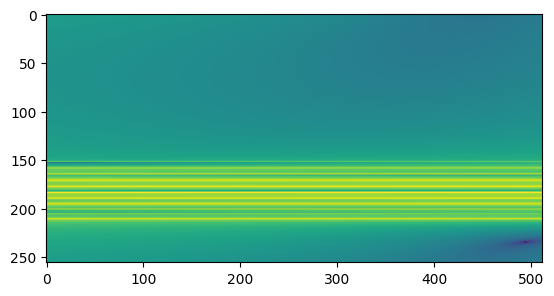

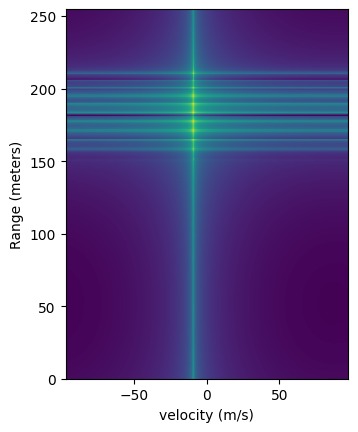

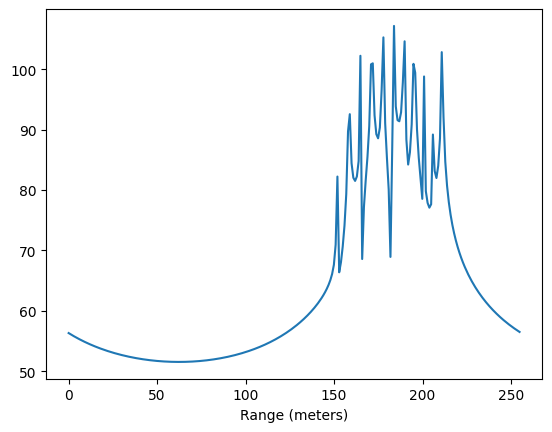

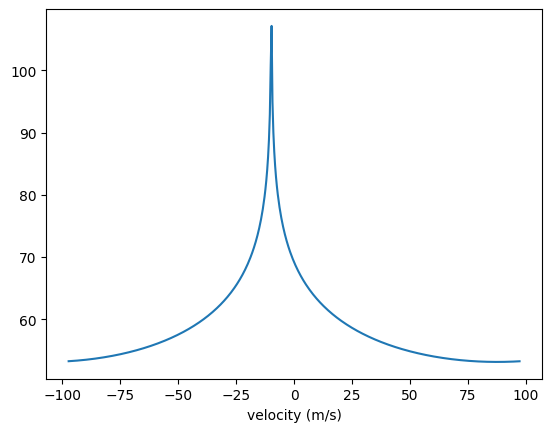

In [164]:
ref = sig[0, 0, :, :]
print(ref.shape)
range_fft = np.fft.fft(ref, axis=0)

def db(x):
    return 20 * np.log10(np.abs(x))

plt.figure()
plt.imshow(db(np.fft.fftshift(range_fft, axes=0)))

doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, axis=1))
plt.figure()
plt.imshow(
    db(doppler_fft),
    extent=[V.min(), V.max(), R.min(), R.max()],
    origin='lower',
)
plt.ylabel('Range (meters)')
plt.xlabel('velocity (m/s)')

r, c = np.unravel_index(
    np.argmax(np.abs(doppler_fft).flatten()),
    doppler_fft.shape
)
rg_cut = doppler_fft[:, c]
dp_cut = doppler_fft[r, :]
plt.figure()
plt.plot(R, db(rg_cut))
plt.xlabel('Range (meters)')

plt.figure()
plt.plot(V, db(dp_cut))
plt.xlabel('velocity (m/s)')

print(V[c])
print(R[r])


(256, 512)


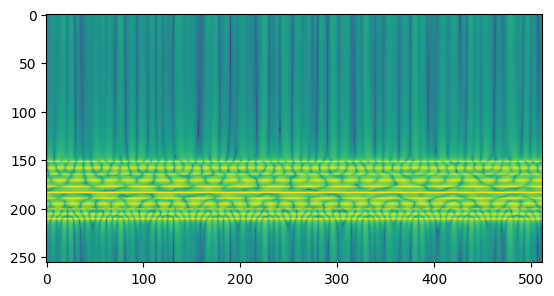

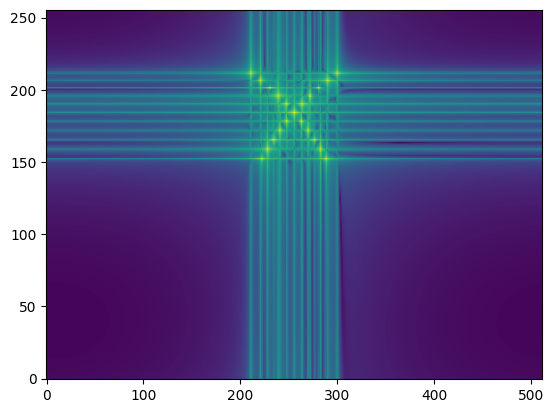

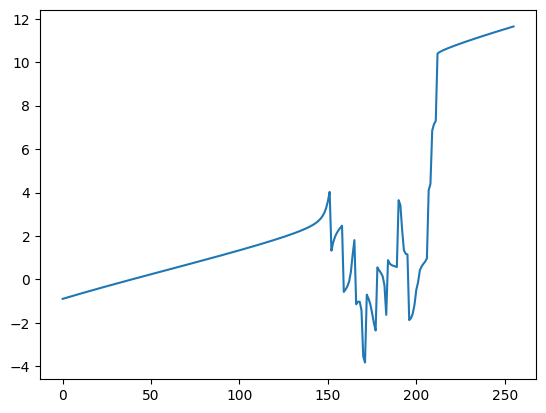

In [165]:
ref_ang = sig[0, :, :, 0].T
print(ref_ang.shape)
range_fft = np.fft.fftshift(np.fft.fft(ref_ang, axis=0), axes=0)

def db(x):
    return 20 * np.log10(np.abs(x))

plt.figure()
plt.imshow(db(range_fft))

angle_fft = np.fft.fftshift(np.fft.fft(range_fft, axis=1), axes=1)
plt.figure()
plt.imshow(
    db(angle_fft[:, ::-1]),  # Reverse just for plotting purposes so azimuth lines up with our perspective 
    aspect='auto',
    origin='lower'
)
# plt.ylim([0, 50])

r, c = np.unravel_index(
    np.argmax(np.abs(range_fft).flatten()),
    range_fft.shape
)
az_cut = range_fft[:, c]    
plt.figure()
plt.plot(np.unwrap(np.angle(az_cut)))

28.64788975654116


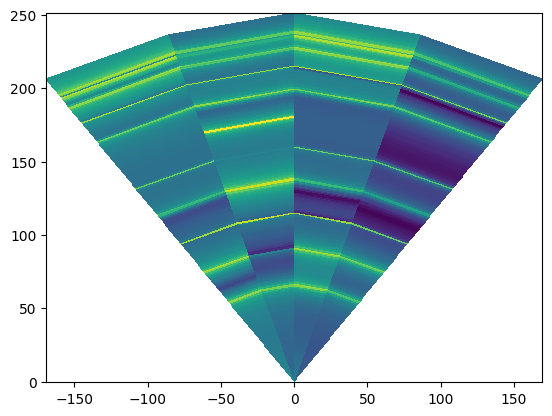

In [124]:
beamwidth = 2 / n_receivers
print(np.rad2deg(beamwidth))

min_az_rad = np.deg2rad(-beamwidth/2)
max_az_rad = np.deg2rad(beamwidth/2)
# Create a grid of vertices that approximate the bounds of each
# radar cell (in polar coordinates).
A = np.linspace(-np.pi/6, np.pi/6, angle_fft.shape[1])
r, az = np.meshgrid(R, A)
# Convert polar to Cartesian coordinates.
grid_x = r * np.cos(az + np.pi/2)
grid_y = r * np.sin(az + np.pi/2)
# plt.figure()
plt.pcolormesh(grid_x.T, grid_y.T, db(angle_fft))
# plt.ylim([0, 50])
# grid_x.shape
# angle_fft.shape

# 5. Range-Angle map (our image!)
- Angle of arrival estimation over our array!